In [ ]:
!pip install tensorflow

In [ ]:
!pip install madmom

     |████████████████████████████████| 20.0MB 82.4MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
  Created wheel for madmom: filename=madmom-0.16.1-cp37-cp37m-linux_x86_64.whl size=20933993 sha256=e096eadfbbf35906a88e6700c7885842f8c2c4132ef59e63a51f9c9b0547db54
  Stored in directory: /root/.cache/pip/wheels/21/0c/30/e0141aa75fb0a829ba5e1dca2be0860dc98502c1789616637d
Successfully built madmom


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
import madmom
import progressbar
import random
from __future__ import print_function, division
import pickle
import warnings


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""


FPS = 100
ONSET_PATH = '/content/gdrive/My Drive/randomsample/'

In [ ]:
class Dataset(object):
    
    def __init__(self, path, audio_suffix='.wav', annotation_suffix='.txt'):
        
        self.path = path
        # populate lists containing audio and annotation files
        audio_files = madmom.utils.search_files(self.path + 'audio', audio_suffix)
        annotation_files = madmom.utils.search_files(self.path + '/annotations', annotation_suffix, recursion_depth=1)
        
        # match annotation to audio files
        self.files = []   #name 
        self.audio_files = audio_files   # name of audios location
        self.audio_files = sorted(audio_files)
        self.annotation_files = annotation_files   # location of annotation files
        self.annotation_files = sorted(annotation_files)
        self.ind=[]   # [0,1,2,3,4...]   indexes
        k=0
        for annotation_file in annotation_files:           
            # search matching audio file
            self.ind.append(k)
            k=k+1
            # save the base name
            self.files.append(os.path.basename(annotation_file[:-len(annotation_suffix)]))
           
        print (self.annotation_files[:5]) 
        print (self.audio_files[:5]) 
        random.shuffle(self.ind)    #shuffling index
        self.ind=np.array(self.ind)      
        
    
            
    def pre_process(self, pre_processor):
        self.x = [pre_processor(file) for file in self.audio_files]
        
    def load_annoatations(self, widen=None):
        self.annotations = [madmom.io.load_onsets(file) for file in self.annotation_files] # list of list (annotation[i]->list)
    
   
        self.sz=len(self.ind)
            
        self.train = self.ind[:3*self.sz//4]
        self.val=self.ind[3*self.sz//4:]
        
        random.shuffle(self.ind) 
        self.test=self.ind[3*self.sz//4:]      
        
    
        
   

   

In [ ]:
onsets_db = Dataset(ONSET_PATH, audio_suffix='.wav')
onsets_db.load_annoatations()

['/content/gdrive/My Drive/randomsample//annotations/audio_100bpm.txt', '/content/gdrive/My Drive/randomsample//annotations/audio_101bpm.txt', '/content/gdrive/My Drive/randomsample//annotations/audio_102bpm.txt', '/content/gdrive/My Drive/randomsample//annotations/audio_103bpm.txt', '/content/gdrive/My Drive/randomsample//annotations/audio_104bpm.txt']
['/content/gdrive/My Drive/randomsample/audio/audio_100bpm.wav', '/content/gdrive/My Drive/randomsample/audio/audio_101bpm.wav', '/content/gdrive/My Drive/randomsample/audio/audio_102bpm.wav', '/content/gdrive/My Drive/randomsample/audio/audio_103bpm.wav', '/content/gdrive/My Drive/randomsample/audio/audio_104bpm.wav']


In [ ]:
print(onsets_db.annotations[0])

[0.  0.6 1.2 1.8 2.4 3.  3.6 4.2]


In [ ]:
from madmom.processors import ParallelProcessor, SequentialProcessor
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.spectrogram import FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor, SpectrogramDifferenceProcessor
        
# define pre-processor
class OnsetPreProcessor(SequentialProcessor):

    def __init__(self, frame_sizes=[1024, 2048, 4096], num_bands=[3, 6, 12]):
        # resample to a fixed sample rate in order to get always the same number of filter bins
        sig = SignalProcessor(num_channels=1, sample_rate=44100)
        # process multi-resolution spec & diff in parallel
        multi = ParallelProcessor([])
        for frame_size, num_bands in zip(frame_sizes, num_bands):
            # split audio signal in overlapping frames
            frames = FramedSignalProcessor(frame_size=frame_size)
            # compute STFT
            stft = ShortTimeFourierTransformProcessor()
            # filter the magnitudes
            filt = FilteredSpectrogramProcessor(num_bands=num_bands)
            # scale them logarithmically
            spec = LogarithmicSpectrogramProcessor()
            # stack positive differences
            diff = SpectrogramDifferenceProcessor(positive_diffs=True, stack_diffs=np.hstack)
            # process each frame size with spec and diff sequentially
            multi.append(SequentialProcessor((frames, stft, filt, spec, diff)))
        # instantiate a SequentialProcessor
        super(OnsetPreProcessor, self).__init__((sig, multi, np.hstack))

# create a callable pre-processor
pp = OnsetPreProcessor()

In [ ]:
onsets_db.pre_process(pp)
#data=OnsetPreProcessor('/content/gdrive/My Drive/Dataset/audio/mridanga16_120bpm.wav')

In [ ]:
pickle.dump(onsets_db, open('/content/gdrive/My Drive/onset_db.pkl', 'wb'), protocol=2)

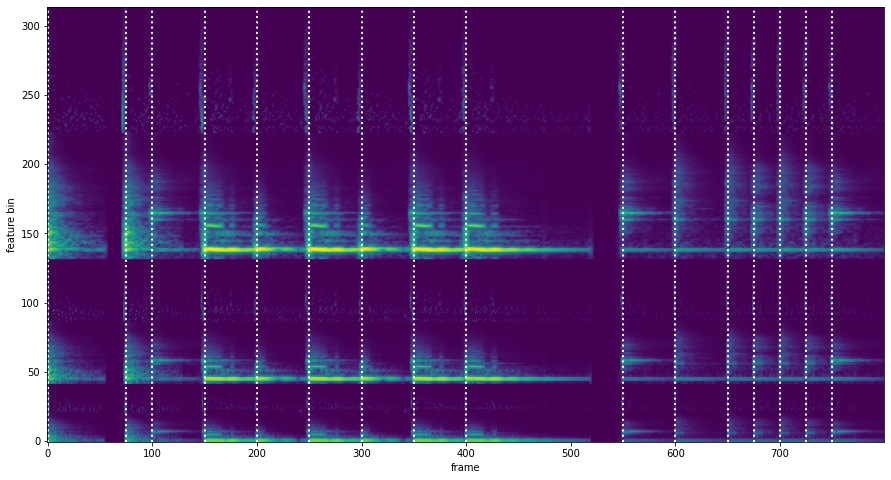

In [ ]:
example = 'mridanga16_120bpm'
example_idx = onsets_db.files.index(example)
plt.imshow(onsets_db.x[example_idx].T, origin='lower', aspect='auto')
plt.xlabel('frame')
plt.ylabel('feature bin')
for ann in onsets_db.annotations[example_idx]:
    plt.axvline(x=ann * FPS, color='w', linestyle=':', linewidth=2)